In [1]:
import numpy as np
from src.sources.fft import FFTSource
import matplotlib.pyplot as plt

from collections import deque
import cv2
import time
import tkinter as tk
from PIL import Image, ImageTk

import math

from src.visualisers.camera_gui import display

This shows how to use masks to create an image from a 1D array - https://stackoverflow.com/questions/49188161/how-to-slice-numpy-rows-using-start-and-end-index

In [2]:
def convert_to_chart(array, max_value=256, flip=True):
    """Convert 1D numpy array to a chart image.
    
    Args:
        array - 1D numpy with data to convert to plot.
        max_value - maximum value in the array.
        flip - boolean flag to correct the output when positive."""
    # Create a "blank", i.e. white with 255, image array
    blank_image = np.ones(shape=(max_value, array.shape[0]))*255
    # Create a 2D mask from the data
    mask = array[:, None] >= np.arange(max_value)
    # Then flip the mask to align with the image and set to 0 (black)
    blank_image[mask.T] = 0
    # We then just need to flip the output again to get back to the original 
    if flip:
        chart_image = np.flipud(blank_image)
    else:
        chart_image = blank_image
    return chart_image

We can use a canvas instead of a label. https://stackoverflow.com/questions/32376679/tkinter-canvas-doesnt-show-entire-photo-image.

## Mean Buffers

Let's have a look at how the mean of the audio changes with different time periods.

In [3]:
class MeanBuffer:
    """This is similar to our sensor and buffer objects."""
    
    def __init__(self, vec_len, time_period):
        """Initialise.
        
        Args:
            time_period - integer period over which to determine the mean.
        """
        self.time_period = time_period
        self.count = 0
        self.running_sum = np.zeros(shape=(vec_len, 1))
        self.buffered_mean = np.zeros(shape=(vec_len, 1))
        
    def iterate(self, input_data):
        """Iterate using input_data."""
        self.count += 1
        self.running_sum += input_data
        # If end of period
        if (self.count) % self.time_period == 0:
            # Replace old buffered mean with new mean
            self.buffered_mean = self.running_sum / self.time_period
            # Reset running sum
            self.running_sum.fill(0)
            # Reset count
            self.count = 0
    
    @property
    def mean(self):
        """Return mean."""
        # If no buffered mean
        if (self.buffered_mean == 0).all():
            mean = (self.running_sum / self.count).astype(np.int16)
        else:
            mean = self.buffered_mean.copy().astype(np.int16)
        return mean
    
    def __repr__(self):
        """Print output."""
        return mean

In [4]:
class MeanAudioGUI:
    
    def __init__(self, sensor, num_of_buffers=8, group_size=2):
        # Setup gui
        self.window = tk.Tk()
        
        # Setup FPS and Quit Button on First Row
        button_frame = tk.Frame(self.window)
        button_frame.pack(expand=True, fill=tk.BOTH)
        # quit button
        self.quit_button = tk.Button(button_frame, text='Quit', command=lambda: self.quit_())
        self.quit_button.pack(side=tk.RIGHT, padx=5, pady=5)
        
        # Create a list of panels for the GUI
        self.panels = list()
        self.canvas_content = list()
        for i in range(num_of_buffers):
            # Create a canvas for each panel
            canvas = tk.Canvas(self.window, width=512, height=64)
            canvas.pack(expand=True, fill=tk.BOTH)
            self.panels.append(canvas)
            self.canvas_content.append(None)
                         
        # Setup sensor
        self.add_sensor(sensor)
        _, data = sensor.read()
        
        # Create mean buffers
        self.num_of_buffers = num_of_buffers
        self.mean_buffers = [MeanBuffer(data.shape[0], group_size**i) for i in range(num_of_buffers)]
        
    def add_sensor(self, sensor):
        """Add a sensor to the GUI for display."""
        self.sensor = sensor
        # Start sensor if not already started
        if not self.sensor.started:
            self.sensor.start()
    
    def update(self):
        # Get audio frame
        _, data = self.sensor.read()
        input_data = data.reshape(-1, 1)
        # Iterate through buffers in reverse
        for mb in reversed(self.mean_buffers):
            mb.iterate(input_data)
            input_data = input_data - mb.mean
        
        # Display the mean values of each buffer
        for i in range(self.num_of_buffers):
            # Convert to image of histogram
            mean = self.mean_buffers[i].mean.ravel()
            positive_chart_image = convert_to_chart(mean)
            negative_chart_image = convert_to_chart(-1*mean, flip=False)
            chart_image = np.concatenate([positive_chart_image, negative_chart_image], axis=0)
            # display(chart_image, self.original_fft)
            pil_image = Image.fromarray(chart_image)
            pil_image = pil_image.resize((512, 64))
            photo_image = ImageTk.PhotoImage(image=pil_image)
            if self.canvas_content[i] is None:
                # print("Creating chart")
                self.canvas_content[i] = self.panels[i].create_image(0, 0, image=photo_image, anchor=tk.NW)
            else:
                # print("Configuring chart")
                self.panels[i].itemconfig(self.canvas_content[i], image=photo_image)
                self.panels[i].image = photo_image
                
        self.window.after(30, self.update)
    
    def run(self):
        self.update()
        self.window.mainloop()
        
    def quit_(self):
        self.sensor.stop()
        self.window.destroy()

Todo:
* ~~Change scale to incorporate negative values.~~
* Scale based on maximum over time.

Observations:
* Certain patterns show up at different scales. E.g. chord changes and beat show up later in the means.
* Lowest few don't show much variation - things happen in the short term.

## Adapting convert_to_chart for negative values

Easiest way is to create two charts - one for negative and one for positive and then graft them together.

Can you just pass a negative version of the array to convert to chart? Then concatenate both along axis=0? Yes.

## Looking at Scales and PBT

We could do with a "panel" class to display each layer of the mean.

## Quick Eigenvalue Decomposition

We can use our trick for 2 and 4 decompositions - shifting then adding or subtracting.

We can have a quick function to do this in 1D.

We can generate a 2D spectrogram from the FFT by buffering over 256 samples, then decompose as per the image. See the bottom of this notebook - https://github.com/benhoyle/predictive_coding/blob/master/2019-07-26%20-%20PCA%20of%20Binary%20Images%20in%20Space%20***.ipynb.

In [5]:
# This is our function for 2D images
def decompose(image):
    """Decompose an image using the Hadamard transform."""
    H = image[1:,:] - image[:-1,:]
    V = image[:,1:] - image[:,:-1]
    # Work out top TLHC + BRHC
    d_1 = image[:-1,:-1] + image[1:,1:]
    # Then work out BLHC + TLHC
    d_2 = image[1:,:-1] + image[:-1,1:]
    D = d_1 - d_2
    # Average is sum of four shifted versions
    A = image[:-1,:-1] + image[1:,:-1] + image[:1,-1] + image[1:,1:]
    return [A, H, V, D]

In [6]:
fft_256 = FFTSource(res_factor=2)
fft_256.start()

In [7]:
_, data = fft_256.read()
data.shape

(274,)

We could do with making this in factors of 2...

In [8]:
# These are from the timebuffer file - we have converted to 1D input data and a 2D case
def add_to_array(array, frame):
    """Add a frame to a rolling array."""
    array = np.roll(array, -1, axis=1)
    # Add frame to end of buffer
    array[..., -1] = frame
    return array

class Buffer:
    """Object for a time buffer."""

    def __init__(self, data_length, time_length):
        """Initialise object.

        Assumes 8-bit values (for now).
        """
        # Set up an array to store a rolling window of inputs
        self.array = np.zeros(
            shape=(data_length, time_length), dtype=np.int16)

    def add(self, frame):
        """Add a frame to the buffer in FF mode."""
        self.array = add_to_array(self.array, frame)
        return None

    @property
    def latest(self):
        """Return latest entry in buffer."""
        return self.forward_array[..., -1]



In [9]:
def norm_scale(a):
    """Normalise array to a scale of 0 to 1."""
    return (a - np.min(a))/np.ptp(a)

In [10]:
def mono_to_RGB(image, white_mode=True):
    """Convert a grayscale signed image to RGB.
    
    Red = positive, green = negative."""
    RGB = np.zeros(shape=(image.shape)+(3, ))
    # Red = positive
    RGB[:, :, 0] = np.maximum(image, 0)
    # Green
    RGB[:, :, 1] = np.maximum(-image, 0)
    if white_mode:
        # Get zero values
        mask = (RGB == 0)
        # set to white
        RGB[mask] = 255
    return RGB

We can maybe have the images as RGBA where 0 is alpha = 0 - search for RGBA here - https://automatetheboringstuff.com/chapter17/.

In [11]:
def mono_to_RGBA(image):
    """Convert a grayscale signed image to RGB.
    
    Red = positive, green = negative."""
    RGBA = np.zeros(shape=(image.shape)+(4, ))
    # Red = positive
    RGBA[:, :, 0] = np.maximum(image, 0)
    # Green
    RGBA[:, :, 1] = np.maximum(-image, 0)
    # Set non-zero values to have alpha  = 255
    nz_rows, nz_cols, _ = RGBA.nonzero()
    RGBA[nz_rows, nz_cols, 3] = 255
    return RGBA

Nah - RGBA is very slow. We could just set all zero values to 255 (white). (See above white mode.) This still slows things down...

## Different Layers / Stages

We can have a frame that extends across the window.
* First frame just shows the original input spectogram.
* Second frame shows the four decomposed images.

In [12]:
class DecomposeFrame:
    """Object to display decomposed images."""
    def __init__(self, parent, subpanels=4, width=256, height=256):
        """Initialise.
        
        Args:
            parent - parent Tk object.
            subpanels - number of subpanels.
            width - subpanel width in pixels.
            height - subpanel height in pixels.
        """
        self.frame = tk.Frame(parent)
        self.frame.pack(side=tk.LEFT, expand=True, fill=tk.BOTH)
        self.panels = list()
        self.canvas_content = list()
        self.width = width
        self.height = height
        for _ in range(subpanels):
            # Create a canvas for each panel
            canvas = tk.Canvas(self.frame, width=width, height=height)
            canvas.pack(side=tk.TOP)
            self.panels.append(canvas)
            self.canvas_content.append(None)
    
    def update(self, images):
        """Update frame with images.
        
        Args:
            images - a set of monochrome, RGB or RGBA arrays.
        """
        # Display the mean values of each buffer
        for i, image in enumerate(images):
            pil_image = Image.fromarray(image)
            pil_image = pil_image.resize((self.width, self.height))
            photo_image = ImageTk.PhotoImage(image=pil_image)
            if self.canvas_content[i] is None:
                # print("Creating chart")
                self.canvas_content[i] = self.panels[i].create_image(0, 0, image=photo_image, anchor=tk.NW)
            else:
                # print("Configuring chart")
                self.panels[i].itemconfig(self.canvas_content[i], image=photo_image)
                self.panels[i].image = photo_image    

In [13]:
def decompose_and_prep(image):
    """Decompose image and prep for display in tkinter.
    
    Args:
        image - numpy 2D array.
    Returns:
        images - list of numpy 2D arrays for display.
    """
    # Decompose
    components = decompose(image)
    # Scale components
    components[0] = components[0] / 4 # HARD CODED 4 - CHANGE to VEC_LEN
    components[1] = mono_to_RGB(components[1])
    components[2] = mono_to_RGB(components[2])
    # As we have two additions and a subtraction we need to additionally scale
    components[3] = mono_to_RGB(components[3]/2)
    # Group images in one list and scale components
    images = [c.astype(np.uint8) for c in components]
    return images

In [14]:
class SpectrogramGUI:
    
    def __init__(self, sensor, run=True):
        # Setup gui
        self.window = tk.Tk()
        
        # Setup FPS and Quit Button on First Row
        button_frame = tk.Frame(self.window)
        button_frame.pack(expand=True, fill=tk.BOTH)
        # quit button
        self.quit_button = tk.Button(button_frame, text='Quit', command=self.quit_)
        self.quit_button.pack(side=tk.RIGHT, padx=5, pady=5)
                         
        # Setup sensor
        self.add_sensor(sensor)
        _, data = sensor.read()
        
        # Hard code the area length as 4
        self.vec_len = 4       
        # Determine the number of stages based on data length and vec_len
        self.num_of_stages = int(math.log(data.shape[0], self.vec_len))
        # We can crop the data to a factor of vec_len
        self.cropped_data_length = self.vec_len**self.num_of_stages
        # Start with a single cuboid buffer that is decomposed
        self.buffer = Buffer(self.cropped_data_length, self.cropped_data_length)
        
        # Create a frame for each stage and pack vertically
        self.frames = [
            DecomposeFrame(self.window, width=128, height=128) 
            for _ in range(self.num_of_stages+4)]
            
        if run:
            self.run()
        
    def add_sensor(self, sensor):
        """Add a sensor to the GUI for display."""
        self.sensor = sensor
        # Start sensor if not already started
        if not self.sensor.started:
            self.sensor.start()
    
    def update(self):
        # Get audio frame
        _, data = self.sensor.read()
        input_data = data[:self.cropped_data_length].reshape(-1, 1)
        # Add to buffer
        self.buffer.add(input_data.ravel())
        # Get buffer image 
        image = 255-self.buffer.array
        # Create a list of lists for display in each frame
        image_lists = [[image.astype(np.uint8)]]
        # Iteratively decompose
        for _ in range(self.num_of_stages+4-1):
            images = decompose_and_prep(image)
            image_lists.append(images)
            # Set the next image as the average of the set
            # image = images[0].astype(np.int16)
            # Set the next image as a down pyramid of the image
            image = cv2.pyrDown(image)
        
        for frame, image_list in zip(self.frames, image_lists):
            frame.update(image_list)
            
        self.window.after(10, self.update)
    
    def run(self):
        self.update()
        self.window.mainloop()
        
    def quit_(self):
        self.sensor.stop()
        self.window.destroy()

In [15]:
sg = SpectrogramGUI(fft_256)

This works but is actually harder to see! 

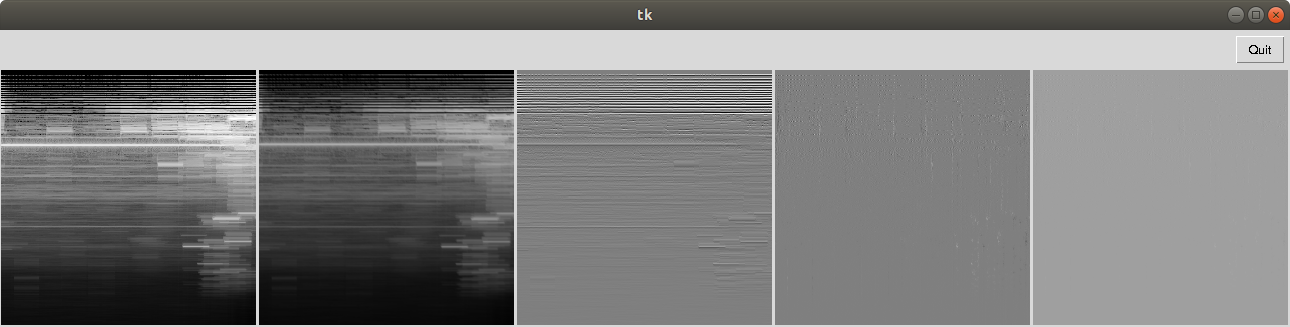

As we have both positive and negative scales, a mid-value of 128 is grey. For display it would be better to have negative as one colour and positive as another colour on a white background.

https://stackoverflow.com/questions/10965417/how-to-convert-a-numpy-array-to-pil-image-applying-matplotlib-colormap

***We could use signs to split into two planes, with zeros for one plane. If RGB. B could be 0, G+ve and R-ve.*** Done.

Getting a little on the slower side - we'll need to watch processing and look for optimisations later.

Awesome!

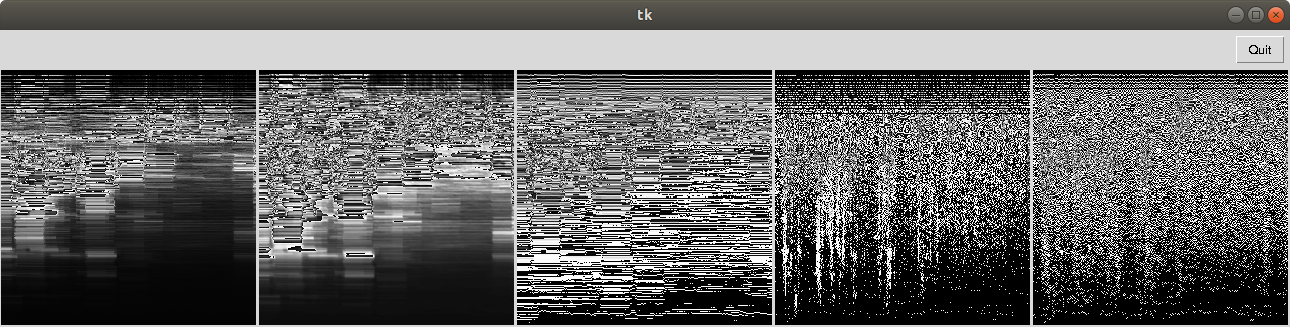

Observations:
* Diagonal appears noiselike and not really containing useful information? Wonder what the eigenvalue is...
* Again the average is informationally not that useful...
* It seems that we take the average and then decompose this at each level into H and V.
* The vertical information is time localised - you get vertical lines for speech. So is the horizontal - words are uniform sized horizontal extends. If we average in time too much would this information get lost? Ah but if we subtracted the lower level estimate the short term features may be enhanced. So the value is not the signal per se but the difference.
* We might need to renormalise the average data - to put it in a range of 0 to 255 as the averaging will naturally cause the values to decrease.
* V on audio is related to beat - mapped to body movement.

***Ah - it's like our original scalespace stuff - WE CAN ONLY SUBSAMPLE AFTER A PARTICULAR NUMBER OF ITERATIONS TO GENERATE THE GAUSSIAN FILTER.***

So now we come full circle. Taking H and V of cv.pyrDown(spectogram) is like passing the spectogram through multiple averaging filters.


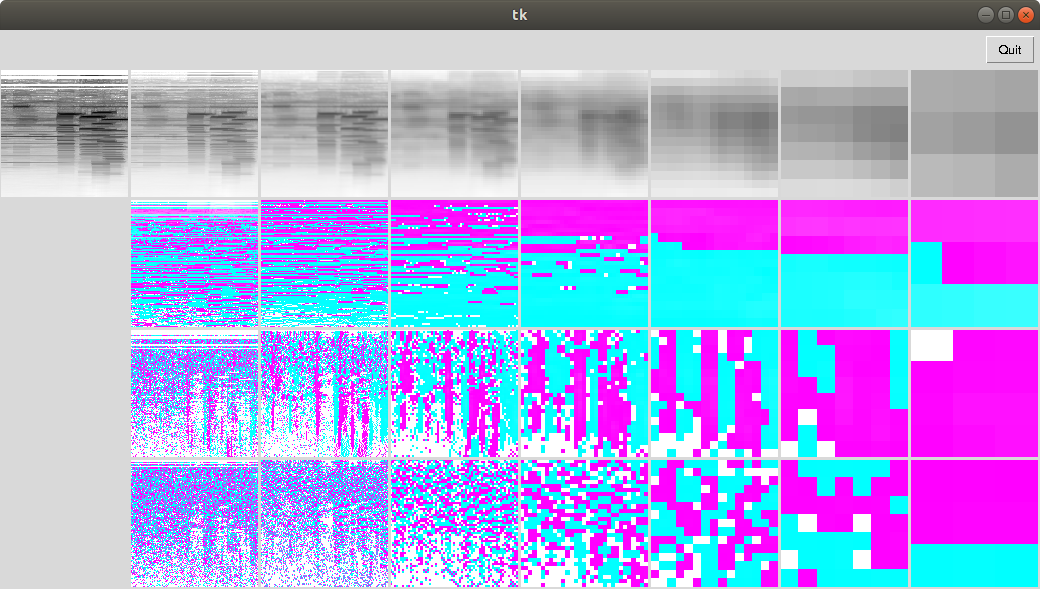

Why are H, V and D values only two values?

In [16]:
image = sg.buffer.array

In [17]:
images = decompose_and_prep(image)

<IPython.core.display.Javascript object>


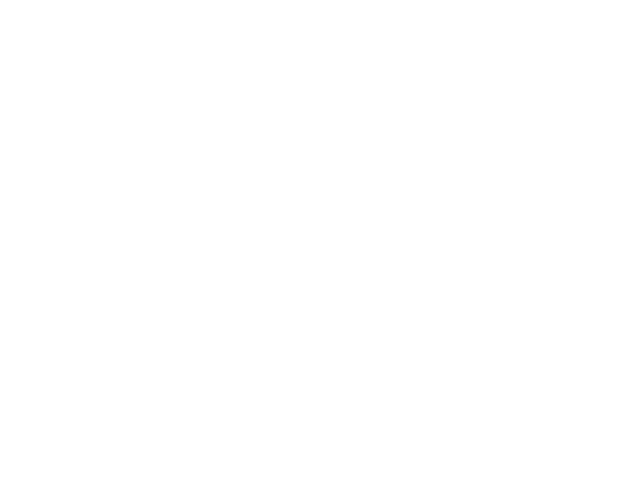

In [18]:
%matplotlib notebook
plt.imshow(images[1])

Ah - it's actually because the values are very small - 1-30.

In [19]:
images[1].max(), np.median(images[1]), images[1].mean()

(255, 255.0, 199.70099571078433)

## Residuals

Taking residuals stop us replicating information at each stage - we only want to look at the information that is added at each stage.

Now there is an option at each stage - do we subtracted an upsampled version of just the stage below or the complete reconstruction of all the stages below?
* If we have input data the two are the same thing - but if we don't have input data we want the upsample of everything below.

In [20]:
plt.semilogy(np.bincount(images[1][:, :, 0].ravel()))

In [21]:
plt.plot(np.bincount(images[1][:, :, 0].ravel()))

plt.plot(np.bincount(images[1][:, :, 1].ravel()), 'r')

In [22]:
plt.plot(np.bincount(images[2][:, :, 0].ravel())/images[2][:, :, 0].ravel().shape[0])

plt.plot(np.bincount(images[2][:, :, 1].ravel())/images[2][:, :, 1].ravel().shape[0], 'r')

x = np.arange(128)
plt.plot(0.25/(x+1)**(3/2), 'g--')

Clipping at 1 would give an approximately balanced distribution as x from 0 to 1.25 integrates to 1/6, i.e. 1/3 for 0.

In [23]:
def create_pyramid(image, reduce="centre"):
    """Create a gaussian image pyramid from the image."""
    # image = reduce_to_2(image, reduce)
    rows, cols = image.shape
    scales = rows.bit_length()-1
    # Create list to hold scales
    pyramid = [image]
    current_image = image
    for i in range(scales):
        rows, cols = current_image.shape
        lower_level = cv2.pyrDown(
            current_image,
            (rows//2, cols//2)
        )
        # Save downsampled array in pyramid
        pyramid.append(lower_level)
        current_image = lower_level
    return pyramid

In [24]:
def upsample(pyramid):
    """Upsample pyramid."""
    # Add the 1x1 pixel reconstruction to the rebuilt list
    upsampled = [pyramid[-1]]
    # Interate through the images and add reconstructed versions
    for image in reversed(pyramid[1:]):
        upsampled.append(cv2.pyrUp(image))
    return upsampled

In [25]:
def get_differences(channel, clip=False):
    """Get stack of differences for a channel."""
    # Create downsampled pyramid
    pyramid = create_pyramid(channel)
    # Create upsampled pyramid
    upsampled = upsample(pyramid)
    # Calculate differences
    if clip:
        # Clip the differences at -1 and 1
        diffs = [np.clip((d-u).astype(np.int8), -1, 1) for d, u in zip(pyramid, reversed(upsampled))]
    else:
        # Don't clip the differences
        diffs = [(d-u).astype(np.int8) for d, u in zip(pyramid, reversed(upsampled))]
    # Ignore last diff as this is a zero pixel
    return diffs[:-1]

For the above to work we need our arrays to be 256 by 256. That's okay - our buffer is 256 by 256.

In [26]:
def decompose_and_prep_residual(image):
    """Decompose image and prep for display in tkinter.
    
    Args:
        image - numpy 2D array.
    Returns:
        images - list of numpy 2D arrays for display.
    """
    # Decompose
    components = decompose(image.astype(np.int16))
    # Scale components
    components[0] = mono_to_RGB(components[0]/2) 
    components[1] = mono_to_RGB(components[1])
    components[2] = mono_to_RGB(components[2])
    # As we have two additions and a subtraction we need to additionally scale
    components[3] = mono_to_RGB(components[3]/2)
    # Group images in one list and scale components
    images = [c.astype(np.uint8) for c in components]
    return images

In [27]:
class ResidualGUI(SpectrogramGUI):
    
    def update(self):
        # Get audio frame
        _, data = self.sensor.read()
        input_data = data[:self.cropped_data_length].reshape(-1, 1)
        # Add to buffer
        self.buffer.add(input_data.ravel())
        # Get buffer image 
        image = 255-self.buffer.array
        # Get list of differences at each stage
        diffs = get_differences(image)
        # Create a list of lists for display in each frame
        image_lists = [[image.astype(np.uint8)]]
        # Iteratively decompose
        for diff in diffs:
            images = decompose_and_prep_residual(diff)
            image_lists.append(images)
        
        for frame, image_list in zip(self.frames, image_lists):
            frame.update(image_list)
            
        self.window.after(10, self.update)
    
    

In [53]:
r_gui = ResidualGUI(fft_256)

ERROR:root:Sampler error occur(l={self.length} and len data={len(data)})


In [29]:
self = r_gui
# Get buffer image 
image = 255-self.buffer.array
# Get list of differences at each stage
diffs = get_differences(image)
# Create a list of lists for display in each frame
image_lists = [[image.astype(np.uint8)]]
# Iteratively decompose
for diff in diffs:
    images = decompose_and_prep(diff)
    image_lists.append(images)

In [30]:
diffs[5]

array([[ 47,  48,  45,  40,  46,  50,  46,  44],
       [ 13,  13,  12,  12,  16,  14,   8,   9],
       [-28, -27, -26, -31, -29, -26, -34, -34],
       [-19, -13, -20, -44, -34, -14, -16, -22],
       [ -4,   3,  -5, -29, -16,   3,   1,  -5],
       [ -4,   2,  -1, -14,  -6,   1,  -2,  -5],
       [  9,  14,  11,   5,  10,  11,   7,   6],
       [ 33,  35,  36,  35,  38,  38,  35,  33]], dtype=int8)

Our decompose and prep method needs adjusting for images that are signed integers...

Yep - we have overflow for the decomposed images.

Average have int8\*4 - so -128\*4 as min and 127\*4 as max - so we need to divide by 4 and add 128
H and V have a subtraction - so we have a range of -128 > 128 subtracted from the same - so min = -255 and max = 255 - should still work okay.
Diagonals have two additions then a subtraction so 128\*2 - 128\*2 - max = 255 - -255 min = -255 - 255 > -512 to 512 - so dividing by 2 should work as well.

In [31]:
image_lists[5][2]

array([[[255, 255, 255],
        [  1, 255, 255],
        [  2, 255, 255],
        [255,   1, 255],
        [255,   7, 255],
        [255,   2, 255],
        [  3, 255, 255],
        [  5, 255, 255],
        [  3, 255, 255],
        [  1, 255, 255],
        [  2, 255, 255],
        [255,   2, 255],
        [255,   4, 255],
        [  1, 255, 255],
        [  5, 255, 255]],

       [[255, 255, 255],
        [255,   1, 255],
        [  2, 255, 255],
        [255,   1, 255],
        [255,   8, 255],
        [255,   2, 255],
        [  4, 255, 255],
        [  3, 255, 255],
        [  1, 255, 255],
        [  1, 255, 255],
        [  5, 255, 255],
        [255,   4, 255],
        [255,   8, 255],
        [  2, 255, 255],
        [ 12, 255, 255]],

       [[  1, 255, 255],
        [255,   2, 255],
        [255,   1, 255],
        [  1, 255, 255],
        [255, 255, 255],
        [  1, 255, 255],
        [  2, 255, 255],
        [  2, 255, 255],
        [255,   3, 255],
        [255,   2, 25

In [32]:
def decompose_and_prep(image):
    """Decompose image and prep for display in tkinter.
    
    Args:
        image - numpy 2D array.
    Returns:
        images - list of numpy 2D arrays for display.
    """
    # Decompose
    components = decompose(image)
    # Scale components
    components[0] = components[0] / 4 # HARD CODED 4 - CHANGE to VEC_LEN
    components[1] = mono_to_RGB(components[1])
    components[2] = mono_to_RGB(components[2])
    # As we have two additions and a subtraction we need to additionally scale
    components[3] = mono_to_RGB(components[3]/2)
    # Group images in one list and scale components
    images = [c.astype(np.uint8) for c in components]
    return images

In [33]:
images = decompose_and_prep(image)

In [34]:
images[0].shape

(255, 255)

In [35]:
plt.imshow(images[0])

/home/ben/anaconda3/envs/var_processor/lib/python3.6/site-packages/matplotlib/image.py:865: UserWarning: Attempted to set non-positive top ylim on a log-scaled axis.
Invalid limit will be ignored.
  self.axes.set_ylim((ymin, ymax), auto=None)


In [36]:
plt.imshow(image[100:150, 100:150])

In [37]:
plt.imshow(images[0][100:150, 100:150])

In [38]:
print(image[100:116, 100:116], "\n---\n", images[0][100:116, 100:116])

[[ 98  95  97  97  86  91  93  94  94  91  91  92  92  91  95  92]
 [ 82  80  79  79  81  80  81  81  81  82  81  81  83  84  85  83]
 [100 105 105 105  94 102  99 100  99 103  99 100 102 103 101 103]
 [105 100 103 103 103 101 105 105 104 103 101 103 107 110 110 109]
 [102 100 100 100  95  94  98  99  98 104 108 107 110 111 111 107]
 [ 88  87  88  88  85  86  88  88  89  89  85  84  83  86  86  87]
 [ 87  86  84  85  89  90  89  89  89  86  84  82  85  83  84  86]
 [ 99  99  97  99  96  95  96  97  95  87  91  91  92  91  93  93]
 [ 96  96  96  96  94  95  96  94  96  95  95  96  95  94  96  96]
 [ 86  86  87  88  87  88  87  88  86  88  89  87  89  85  90  88]
 [ 68  67  66  65  65  66  66  66  66  67  69  67  67  66  68  66]
 [ 42  41  40  40  40  41  41  41  41  41  41  38  39  42  42  47]
 [ 47  46  47  47  47  47  46  46  46  46  46  54  55  59  69  66]
 [ 61  59  60  60  60  60  61  60  57  59  68  78  78  78  74  78]
 [ 80  73  72  73  72  72  73  72  77  77  79  81  80  82  81 

Why does the average reduce the intensity?

In [39]:
images_l2 = decompose_and_prep(images[0].astype(np.int16))

In [40]:
plt.imshow(images_l2[0][100:150, 100:150])

In [41]:
images_l2[0].shape

(254, 254)

In [42]:
plt.imshow(images_l2[0])

In [43]:
print(image[100:116, 100:116], images[0][100:116, 100:116], images_l2[0][100:116, 100:116], sep="\n---\n")

[[ 98  95  97  97  86  91  93  94  94  91  91  92  92  91  95  92]
 [ 82  80  79  79  81  80  81  81  81  82  81  81  83  84  85  83]
 [100 105 105 105  94 102  99 100  99 103  99 100 102 103 101 103]
 [105 100 103 103 103 101 105 105 104 103 101 103 107 110 110 109]
 [102 100 100 100  95  94  98  99  98 104 108 107 110 111 111 107]
 [ 88  87  88  88  85  86  88  88  89  89  85  84  83  86  86  87]
 [ 87  86  84  85  89  90  89  89  89  86  84  82  85  83  84  86]
 [ 99  99  97  99  96  95  96  97  95  87  91  91  92  91  93  93]
 [ 96  96  96  96  94  95  96  94  96  95  95  96  95  94  96  96]
 [ 86  86  87  88  87  88  87  88  86  88  89  87  89  85  90  88]
 [ 68  67  66  65  65  66  66  66  66  67  69  67  67  66  68  66]
 [ 42  41  40  40  40  41  41  41  41  41  41  38  39  42  42  47]
 [ 47  46  47  47  47  47  46  46  46  46  46  54  55  59  69  66]
 [ 61  59  60  60  60  60  61  60  57  59  68  78  78  78  74  78]
 [ 80  73  72  73  72  72  73  72  77  77  79  81  80  82  81 

***Ah - it's like our original scalespace stuff - WE CAN ONLY SUBSAMPLE AFTER A PARTICULAR NUMBER OF ITERATIONS TO GENERATE THE GAUSSIAN FILTER.***

So now we come full circle. Taking H and V of cv.pyrDown(spectogram) is like passing the spectogram through multiple averaging filters.

In [44]:
# Split H into RGB with +ve and -ve - 
# see https://stackoverflow.com/questions/41843585/python-break-numpy-array-into-positive-and-negative-components
RGB = np.zeros(shape=(H.shape)+(3, ))
# Red = positive
RGB[:, :, 0] = np.maximum(H, 0)
# Green
RGB[:, :, 1] = np.maximum(-H, 0)
plt.imshow(RGB)

NameError: name 'H' is not defined

In [ ]:
H.shape + (3, )

In [ ]:
np.nonzero(RGB[:, :, 0])[1].max()

In [ ]:
RGB.nonzero()

In [ ]:
RGB[np.nonzero(RGB[:, :, 0])[0], np.nonzero(RGB[:, :, 0])[1], 3] = 255

In [ ]:
RGBA = mono_to_RGBA(H)

In [ ]:
RGBA.shape

In [ ]:
plt.imshow(RGBA)

In [ ]:
positive_H = (H + 255)//2; print(positive_H.dtype, positive_H.max(), positive_H.min())

Ah so we only need to add 255 once. For V this is the same. For D, we add to images - so each has min 0 and max 512, then we subtract so we can have max 512 and min -512

In [ ]:
V = image[:,1:] - image[:,:-1]
# Work out top TLHC + BRHC
d_1 = image[:-1,:-1] + image[1:,1:]
# Then work out BLHC + TLHC
d_2 = image[1:,:-1] + image[:-1,1:]
D = d_1 - d_2
# Average is sum of four shifted versions
A = image[:-1,:-1] + image[1:,:-1] + image[:1,-1] + image[1:,1:]

In [ ]:
_, data = fft_256.read()

In [ ]:
data.max()

In [ ]:
plt.plot(data)

## PBT with Residuals

In [51]:
from src.var_processor.pb_threshold import ternary_pbt, pb_threshold

class PBTGUI(SpectrogramGUI):
    
    def update(self):
        # Get audio frame
        _, data = self.sensor.read()
        input_data = data[:self.cropped_data_length].reshape(-1, 1)
        # Add to buffer
        self.buffer.add(input_data.ravel())
        # Get buffer image 
        image = 255 - self.buffer.array
        # Get list of differences at each stage
        """
        # Gives us crazy patterns
        pbt = pb_threshold(image).astype(np.uint8)
        diffs = get_differences(pbt*255)
        """
        diffs = get_differences(image)
        # Create a list of lists for display in each frame
        image_lists = [[image.astype(np.uint8)]]
        # Iteratively decompose
        for diff in diffs:
            images = decompose_and_prep_residual(diff)
            image_lists.append(images)
        
        for frame, image_list in zip(self.frames, image_lists):
            frame.update(image_list)
            
        self.window.after(10, self.update)
    

In [52]:
pbt = PBTGUI(fft_256)

ERROR:root:Sampler error occur(l={self.length} and len data={len(data)})


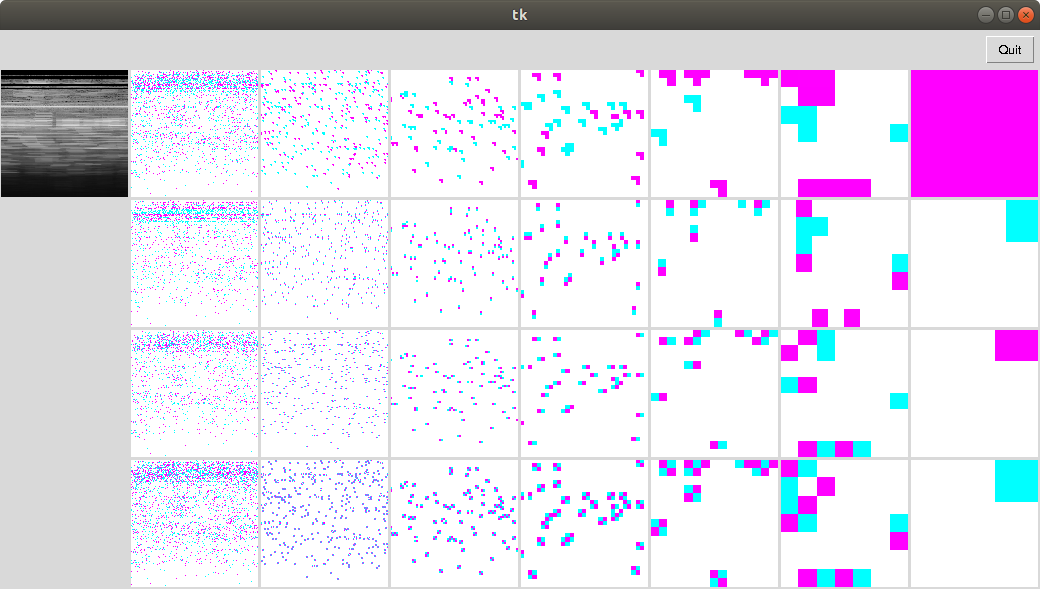

Very hard to see the patterns - just looks random.

But the patterns over time should be there. 

You can see the size of the filters in the random points - should this be the case?

Also why are the vertical points horizontal in orientation and vice-versa? 

CPU appears to struggle with this.